In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Generate dataset
def generate_dataset():
    start_date = datetime(2024, 1, 1)
    dates = [(start_date + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(365)]
    
    ROOM_TYPES = ['Single', 'Double', 'Suite', 'Deluxe Suite']
    ROOM_TYPE_PROBABILITIES = [0.4, 0.4, 0.1, 0.1]
    BASE_PRICES = {'Single': 80, 'Double': 120, 'Suite': 250, 'Deluxe Suite': 400}
    
    data = []
    for date in dates:
        month = int(date.split('-')[1])
        for _ in range(10):  # Reduced from 100 to 10 per day
            room_type = np.random.choice(ROOM_TYPES, p=ROOM_TYPE_PROBABILITIES)
            num_beds = 1 if room_type == 'Single' else 2
            temperature = round(np.random.normal(20, 8), 1)  # Simulated temperature
            room_sizes = {'Single': (10, 20), 'Double': (15, 25), 'Suite': (30, 45), 'Deluxe Suite': (45, 70)}
            room_size = round(np.random.uniform(*room_sizes[room_type]), 1)
            occupancy_rate = round(np.random.beta(a=2, b=5) * 100, 1)
            
            # Price Modifiers
            seasonal_mult = 1.3 if month in [6, 7, 8] else 1.2 if month in [12, 1] else 1.0
            weather_mult = 1.05 if temperature > 25 else 0.95 if temperature < 10 else 1.0
            size_mult = 1 + (room_size - 15) / 100
            occupancy_mult = 1 + (occupancy_rate / 100) * 0.5
            
            final_price = round(BASE_PRICES[room_type] * seasonal_mult * weather_mult * size_mult * occupancy_mult, 2)
            
            data.append({
                'date': date,
                'room_type': room_type,
                'num_beds': num_beds,
                'temperature': temperature,
                'room_size': room_size,
                'occupancy_rate': occupancy_rate,
                'final_price': final_price
            })
    
    return pd.DataFrame(data)

In [4]:
# Create dataset
df = generate_dataset()

In [5]:
# Save dataset to CSV
df.to_csv('room_pricing_data.csv', index=False)
print("Dataset saved as room_pricing_data.csv")

Dataset saved as room_pricing_data.csv


In [6]:
# One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(df[['room_type']])
df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['room_type']))
df = pd.concat([df, df_encoded], axis=1).drop(columns=['room_type'])

In [7]:
# Handling Missing Values
imputer = SimpleImputer(strategy='mean')
df[['temperature', 'room_size', 'occupancy_rate', 'final_price']] = imputer.fit_transform(df[['temperature', 'room_size', 'occupancy_rate', 'final_price']])

In [8]:
# Normalize Numerical Features
scaler = StandardScaler()
numeric_cols = ['temperature', 'room_size', 'occupancy_rate', 'final_price']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]),
 [Text(0, 0, '2024-06-11'),
  Text(1, 0, '2024-12-09'),
  Text(2, 0, '2024-01-05'),
  Text(3, 0, '2024-05-17'),
  Text(4, 0, '2024-02-11'),
  Text(5, 0, '2024-07-19'),
  Text(6, 0, '2024-08-19'),
  Text(7, 0, '2024-03-14'),
  Text(8, 0, '2024-03-27'),
  Text(9, 0, '2024-12-12'),
  Text(10, 0, '2024-10-12'),
  Text(11, 0, '2024-08-21'),
  Text(12, 0, '2024-09-30'),
  Text(13, 0, '2024-06-21'),
  Text(14, 0, '2024-06-10'),
  Text(15, 0, '2024-09-14'),
  Text(16, 0, '2024-12-10'),
  Text(17, 0, '2024-07-02'),
  Text(18, 0, '2024-11-19'),
  Text(19, 0, '2024-10-05'),
  Text(20, 0, '2024-12-08'),
  Text(21, 0, '2024-07-01')

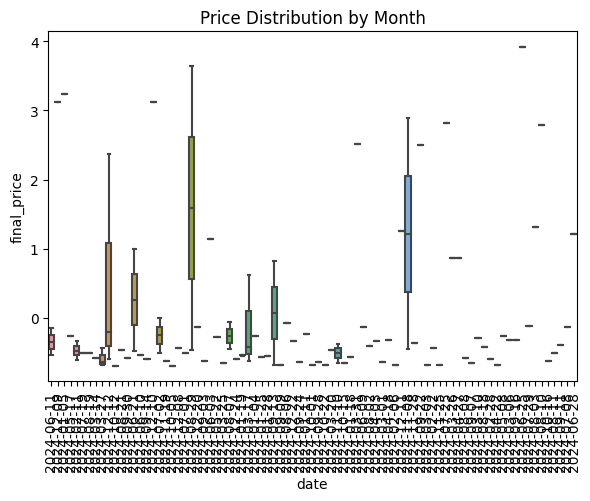

In [9]:
# Data Visualization
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='date', y='final_price', data=df.sample(100))
plt.title('Price Distribution by Month')
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Correlation Matrix')

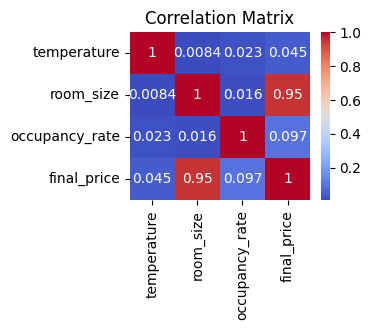

In [10]:
plt.subplot(2, 2, 2)
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

Text(0.5, 1.0, 'Room Size vs Price')

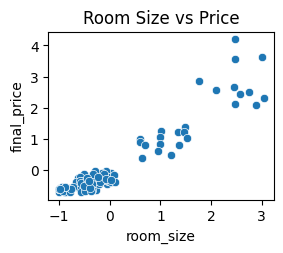

In [11]:
plt.subplot(2, 2, 3)
sns.scatterplot(x='room_size', y='final_price', data=df.sample(100))
plt.title('Room Size vs Price')


Text(0.5, 1.0, 'Occupancy Rate vs Price')

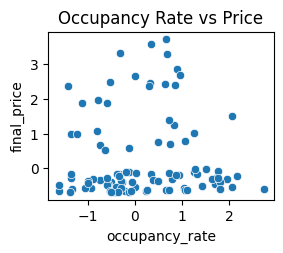

In [12]:
plt.subplot(2, 2, 4)
sns.scatterplot(x='occupancy_rate', y='final_price', data=df.sample(100))
plt.title('Occupancy Rate vs Price')

In [13]:
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [14]:
# Train-Test Split
X = df.drop(columns=['final_price', 'date'])
y = df['final_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Machine Learning Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

In [16]:
# Training and Evaluation
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

Linear Regression: RMSE = 0.1936, R² = 0.9609
Random Forest: RMSE = 0.1872, R² = 0.9634
XGBoost: RMSE = 0.1921, R² = 0.9615
